# Jupyter notebook: sgRNA sequence motifs correlating with repression strength

## Overview

This Jupyter notebook is an attempt to identify sequence motifs or variants in sgRNAs that improve or decrease the efficiency of CRISPRi reression.

## Background

Two CRISPRi libraries are available for Synechocystis, version 1.0 with only 2 sgRNAs and version 2.0 with on average 5 sgRNAs per gene.
Each sgRNA targets the 5'-region of a gene, meaning the transcription start site (TSS) or the region downstream of it.
The sgRNA mediates the binding efficiency of the dCas9 enzyme. However, previous and current sequencing results show that the repression strength is by no means uniform.
In fact, variation between the efficiency of sgRNAs mediating repression is enormous. Repression efficiency is partly influenced by the distance to the TSS, and partly
by unknown sequence features. Such features could be:

- folding, secondary structures, such as hairpins
- off target binding (competitive binding)
- GC content
- so far unknown motifs

For details regarding the ongoing efforts to determine all gene's fitness contribution, see the [CRISPRi library github repository](https://github.com/m-jahn/R-notebook-crispri-lib) that contains this notebook and further information. The R analysis pipeline that led to the selection of the ncRNAs of interest can be viewed on [m-jahn.github.io](https://m-jahn.github.io/R-notebook-crispri-lib/CRISPRi_V2_data_processing.nb.html).

Tasks:

- import sgRNA sequences
- import sgRNA fitness data and merge with sequences
- group sgRNAs in different binding classes (or continuous target variable?)
- determine sequence motifs that lead to high repression efficiency and/or correlation
- determine sequence motifs that lead to low repression

Strategy:

- nucleotide sequence is available, needs to be trimmed and aligned
- can be one-hot-encoded by position and nucleotide (pos1_A: T/F, pos1_T: T/F, ...)
- test and apply different ML models:
  - tree-based models including feature importance: Random Forest (RF), gradient boosting (GB)
  - NN-based models without feature importance: MLP, CNN


## Import of required libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import Bio.SeqIO
import Bio.SeqUtils
from requests import get
from io import StringIO

## Data import and re-arrangement

The first task is to import the sequence data from a fasta file into a data frame.
The data is stored as reference "genome" for read mapping, in the [CRISPRi NGS pipeline](https://github.com/m-jahn/CRISPRi-lib-pipe/) on github.

In [2]:
dir_fasta_db = "https://github.com/m-jahn/CRISPRi-lib-pipe/raw/main/ref/Synechocystis_v2.fasta"
con_fasta_db = get(dir_fasta_db, allow_redirects = True)
fasta_db = Bio.SeqIO.parse(StringIO(con_fasta_db.text), "fasta")
print(fasta_db)

In [3]:
# iterate through fasta DB connection and save results to list
fivep_adapter = "CAGTGATAGAGATACTGGGAGCTA"
threep_adapter = "GTTTTAGAGCTAGAAATAGCAAGTTAAAAT"

fasta_id = []
fasta_seq = []
for fasta_record in fasta_db:
    fasta_id.append(fasta_record.id)
    threep_pos = fasta_record.seq.find(threep_adapter)
    fasta_seq.append(fasta_record.seq[len(fivep_adapter) : threep_pos])

In [4]:
# make new pd data frame from lists
fasta_df = pd.DataFrame()

In [5]:
fasta_df["sgRNA"] = fasta_id
fasta_df["seq"] = fasta_seq
fasta_df["seq_len"] = [len(str(i)) for i in fasta_seq]

The second task is to import the main data table with fitness, correlation and repression efficiency for every sgRNA.

In [6]:
data = pd.read_csv("../data/output/fitness_sgRNA.csv")
data.iloc[:, 0:14].head(n = 5)

,sgRNA,sgRNA_target,sgRNA_position,condition,time,log2FoldChange,fitness,sgRNA_index,sgRNA_type,locus,sgRNA_correlation,sgRNA_efficiency
0,aat|22,aat,22,"HC, HL",0,0.000000,0.060240,1,gene,sll0869,0.495179,0.402167
1,aat|22,aat,22,"HC, HL",4,0.011120,0.060240,1,gene,sll0869,0.495179,0.402167
2,aat|22,aat,22,"HC, HL",8,0.054991,0.060240,1,gene,sll0869,0.495179,0.402167
3,aat|22,aat,22,"HC, HL",10,0.091747,0.060240,1,gene,sll0869,0.495179,0.402167
4,aat|22,aat,22,"HC, IL",0,0.000000,0.354815,1,gene,sll0869,0.495179,0.402167


The data frame needs to be reduced/summarized to the desired shape. We don't need fitness and log2FC for all conditions and time points.
All we need instead is 1 sgRNA per row, with:

- mean absolute fitness effect over all conditions
- repression efficiency (relative score between 0 and 1)
- correlation (also relative score between 0 and 1)

In [7]:
data_reduced = data[["sgRNA", "sgRNA_target", "sgRNA_position", "sgRNA_correlation", "sgRNA_efficiency", "fitness"]]

In [8]:
data_reduced = data_reduced.drop_duplicates()

In [9]:
# summarize all sgRNAs to mean abs fitness etc
data_reduced["fitness"] = abs(data_reduced["fitness"])
data_reduced = data_reduced.groupby(["sgRNA_target", "sgRNA"]).mean()

## Preparation for ML training and tuning

1. Remove non-responsive genes (no sgRNA has an effect on fitness)
2. Choose and optionally scale/bin target variable
3. One-hot encode sgRNA sequences
4. Split data into training and test data set

### Task 1: Remove non-responsive genes

Plot distribution of sgRNA fitness.

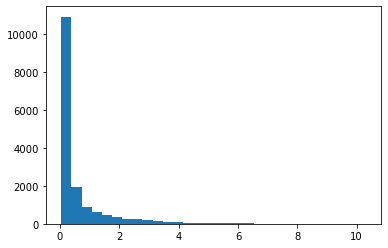

In [10]:
plt.hist(abs(data_reduced["fitness"]), bins = 30);

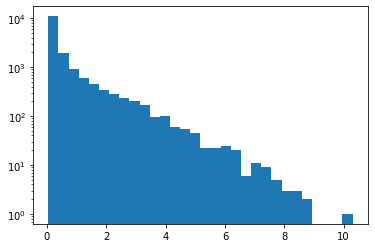

In [11]:
plt.hist(abs(data_reduced["fitness"]), bins = 30, log=True);

In [12]:
# filter all genes out where no sgRNA exceeds fitness effect > 1 in any condition
list_max_fitness = data_reduced.groupby("sgRNA_target")["fitness"].max()

In [13]:
list_max_fitness = list_max_fitness[abs(list_max_fitness) > 1]

In [14]:
data_reduced = data_reduced.reset_index().merge(list_max_fitness, on = "sgRNA_target")
#data_reduced = data_reduced.query('sgRNA_correlation > 0.5')
data_reduced.head(5)

,sgRNA_target,sgRNA,sgRNA_position,sgRNA_correlation,sgRNA_efficiency,fitness_x,fitness_y
0,Era,Era|10,10.0,0.981797,0.308089,0.974606,3.522669
1,Era,Era|25,25.0,0.972385,0.622677,1.861402,3.522669
2,Era,Era|39,39.0,0.975454,0.218752,0.885958,3.522669
3,Era,Era|64,64.0,0.976020,0.290091,0.907332,3.522669
4,Era,Era|76,76.0,0.610723,1.000000,3.522669,3.522669


### Task 2: Scale and bin target variable

Target variable is sgRNA efficiency, a relative score between 0 (no effect on fitness) and 1 (maximum effect on fitness).
Scaling can therefore be omitted.

- if target variable is taken as is, the ML problem becomes a regression problem
- if target variable is binned into e.g. 5 bins of width 0.2, the problem becomes a classification problem
- choose simplest possible classification in high and low efficcieny sgRNAs


In [15]:
list_bins = ["0-low", "1-high"] #["0-low", "1-med", "2-high"]
data_reduced["efficiency_binned"] = pd.cut(data_reduced["sgRNA_efficiency"], len(list_bins), labels = list_bins)

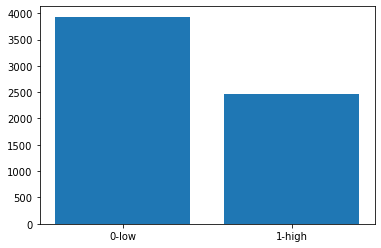

In [16]:
data_bin_sum = data_reduced.groupby("efficiency_binned").size()
plt.bar(x = data_bin_sum.index, height=data_bin_sum);

### Task 3: Prepare feature matrix

- Alignment to left (5') or right (3') end, because sgRNA length varies
- sgRNAs have variable length. Need to trim and/or pad them to a common length
- One hot encoding of sgRNA sequences

In [17]:
# filter fasta df to only sgRNAs that show an effect (common set with data)
fasta_df_reduced = pd.merge(fasta_df, data_reduced, how = 'inner', on = 'sgRNA')
print(min(fasta_df_reduced.seq_len), max(fasta_df_reduced.seq_len))

17 22


In [18]:
# align seq by trimming or padding with N to predefined same length
def align_and_pad(seq, n_max = 25, complement = False):
    len_seq = len(seq)
    if complement:
        seq = seq.reverse_complement().complement()
        if len_seq < n_max:
            seq = seq + "N"*(n_max-len_seq)
        elif len_seq > n_max:
            seq = seq[ : n_max]
    else:
        if len_seq < n_max:
            seq = "N"*(n_max-len_seq) + seq
        elif len_seq > n_max:
            seq = seq[len_seq-n_max : ]
    return(seq)
    
# test inversion and padding
print(align_and_pad(fasta_df_reduced.seq[0], n_max = 22))

NNNNNATGTCGGCGGTGACCCG


In [19]:
# apply to all sgRNAs
fasta_df_reduced["seq_pad"] = [align_and_pad(i, n_max = 22) for i in fasta_df_reduced.seq]

**Shape of the data as input for scikit learn**

- data is always a 2D array, shape (n_samples, n_features)
- features should be **one hot encoded**: all cateogrical variables are spread to an list/array with binary encoding (0 OR 1) for yes and no

In [20]:
def onehot(s):
    z = []
    for nt in str(s):
        if not nt in "AaCcGgTtNn":
            print("Non-ATGCU character: " + nt)
            raise Exception
        if nt in "Aa": z.append(1)
        else: z.append(0)
        if nt in "Cc": z.append(1)
        else: z.append(0)
        if nt in "Gg": z.append(1)
        else: z.append(0)
        if nt in "Tt": z.append(1)
        else: z.append(0)
        if nt in "Nn": z.append(1)
        else: z.append(0)
    return(z)

In [21]:
fasta_df_reduced["seq_onehot"] = fasta_df_reduced.seq_pad.apply(onehot)

- finally turn pd.Series/DF into an array with dimensions n_observations x n_features
- also turn target variable into an array of length n_observations

In [22]:
array_fasta = np.array(fasta_df_reduced.seq_onehot.to_list())
array_target = fasta_df_reduced.efficiency_binned.to_numpy()

- split into training and validation set (80%/20%)

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit

# split data automatically with this short hand
x_train, x_test, y_train, y_test = train_test_split(array_fasta, array_target, test_size = 0.25, random_state = 42)
# obtain also indices to select rows of the original data
for i_train, i_test in ShuffleSplit(n_splits = 1, test_size = 0.25, random_state = 42).split(array_fasta):
    print('Number of observations for training data: ' + str(len(i_train)))
    print('Number of observations for test data: ' + str(len(i_test)))

Number of observations for training data: 4797
Number of observations for test data: 1599


## Logos to visualize sequence motifs

- logos are visualizations for nucleotide probability or prevalence of a set of aligned sequences
- can use the python package `logomaker` installed with `pip install logomaker`
- separate logos for low, (medium), high efficiency sgRNAs

In [24]:
import logomaker

In [25]:
# define colors for the four bases
colors = {'A': '#E7298A', 'C': '#66A61E', 'G': '#E6AB02', 'T': '#999999'}

In [26]:
# function to take a pd.Series with sequences as input and plot a logo
def plot_logo(data, to_type = 'weight', ignore = 'N', title = '', ylim = [-0.85, 0.6]):
    data_str = [str(i) for i in data]
    data_logo = logomaker.alignment_to_matrix(
        data_str, to_type = to_type,
        characters_to_ignore = ignore)
    data_logo.index = data_logo.index + 1
    title = '{0} (n = {1})'.format(title, len(data_str))
    logo = logomaker.Logo(
        data_logo,
        fade_below = 0.33,
        color_scheme = colors
    )
    logo.ax.set_ylim(ylim)
    logo.ax.text(0, ylim[1]+0.05, title,fontsize = 14)
    logo.ax.set_xticks(np.arange(2,len(data_str[0])+1,2))

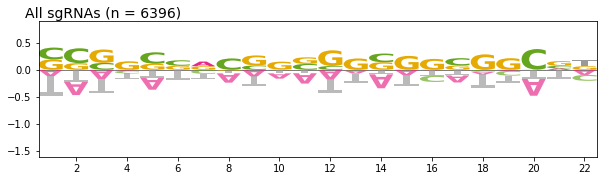

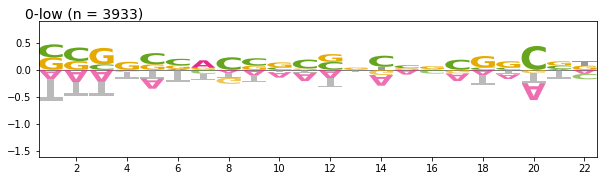

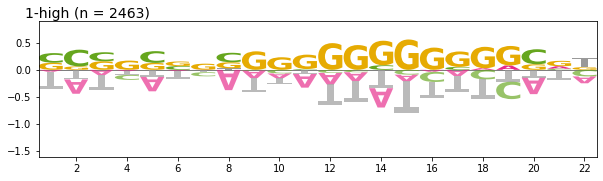

In [27]:
# Logo for ALL sgRNAs combined
plot_logo(fasta_df_reduced.seq_pad, title = 'All sgRNAs', ylim = [-1.6, 0.9])
plt.savefig('../figures/logo_all.pdf')

# Logo for LOW EFFICIENCY sgRNAs
for i in list_bins:
    plot_logo(
        data = fasta_df_reduced.query('efficiency_binned == "' + i + '"').seq_pad,
        title = i,
        ylim = [-1.6, 0.9])
    plt.savefig('../figures/logo_' + i + '.pdf')

Conclusions:

- clear relationship of sgRNA sequence and repression efficiency
- high efficiency sgRNAs enriched for 'G' and depleted for 'A' or 'T' in position 4-14 proximal to PAM site
- low efficiency sgRNAs are not enriched for a specific sequence pattern (no neg. selection criterion)
- med efficiency sgRNAs are in fact a mixture of the two above patterns (slight enrichment of 'G' stretch)

## Model 1: Support vector machine

Some useful advice from the scikit-learn page

- Avoiding data copy: Data passed to certain methods will be copied before calling the underlying C implementation. Check if numpy array is C-contiguous by inspecting its flags attribute
- Kernel cache size: has a strong impact on run times for larger problems. If you have enough RAM available, increase cache_size to a higher value
- Setting C: C is 1 by default and it’s a reasonable default choice. If you have a lot of noisy observations you should decrease it
- Larger C values will take more time to train, sometimes up to 10 times longer
- SVM algorithms are not scale invariant, so it is highly recommended to scale your data (scale all features to [0,1] or [-1,+1]. This was done in our example.
- Kernel functions: can be  one of linear (most simple), polynomial (`degree`, `coef0`), radial basis function (RBF, `gamma` > 0) or sigmoid (`coef0`)

Important parameters for fitting:

- `kernel`: the main parameter that determines the type of hyperplane for dividing n-D feature vectors
- `n_jobs = -1`: uses all cores instead of 1 (the default)
- `cv`: number of k-fold cross validations, default 5 can be left

In [28]:
from sklearn import svm
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [29]:
%%time
# Model tuning
param_grid = {
    'kernel': ['rbf', 'linear'],
    'C': [0.5, 0.75, 1, 1.5, 2],
    'gamma': [0.01, 0.05, 0.1, 0.5, 1, 5]}
SVM = svm.SVC(random_state = 42)
SVM_tune = GridSearchCV(SVM, param_grid, n_jobs = -1)
SVM_tune.fit(x_train[: 2000], y_train[: 2000])
print(SVM_tune.best_params_)

{'C': 0.75, 'gamma': 0.05, 'kernel': 'rbf'}
CPU times: user 1.59 s, sys: 115 ms, total: 1.71 s
Wall time: 1min 50s


In [30]:
# Model fitting & prediction
SVM = svm.SVC(**SVM_tune.best_params_, probability = True, class_weight = "balanced")
SVM_fit = SVM.fit(x_train, y_train)
SVM_pred = SVM_fit.predict(x_test)

Evalauation of model performance:

- `precision` = fraction of relevant instances among the retrieved instances (TP/(TP+FP))
- `recall` = fraction of relevant instances that were retrieved (also called sensitivity, TP/(TP+FN))
- `f1-score` = harmonic mean of the precision and recall, best value at 1 and worst at 0
- `specificity` - fraction of non-relevant instances that were retrieved (TN/(TN+FP))

In [31]:
print("SVM train accuracy: %0.3f" % SVM_tune.score(x_test, y_test))
print(classification_report(y_test, SVM_pred))

SVM train accuracy: 0.663
              precision    recall  f1-score   support

       0-low       0.72      0.65      0.68      1019
      1-high       0.47      0.54      0.50       580

    accuracy                           0.61      1599
   macro avg       0.59      0.60      0.59      1599
weighted avg       0.63      0.61      0.62      1599



- test predictive power of the model
- predict classes of validation data set and make confusion matrix

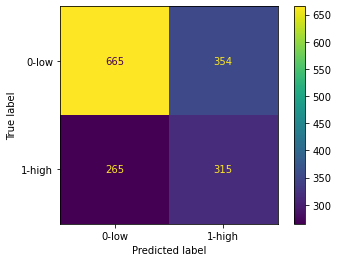

In [32]:
# x-axis: predictions; y-axis: ground truth
SVM_cm = confusion_matrix(y_test, SVM_pred, labels = SVM_fit.classes_)
SVM_cmplot = ConfusionMatrixDisplay(SVM_cm, display_labels = SVM_fit.classes_)
SVM_cmplot.plot();

## Model 2: Random Forest

- Both model types decision tree based, RF with global tree refinement, GBM with local iterative refinement
- Fully tractable models: not only prediction of classes, but also feature importance
- Very important aspect of our question: Which positions/nucleotides of the sgRNA are particularly important?
- This question is almost more important than prediciting quality of sgRNAs, as it can be used to derive generalized rules

In [33]:
from sklearn.ensemble import RandomForestClassifier

In [34]:
%%time
# Model tuning
param_grid = {
    'n_estimators': [20, 50, 100, 200, 300, 400],
    'max_features': ['auto', 'sqrt'],
    'max_depth': [5, 10, 25, 50, 100]}

RF = RandomForestClassifier(random_state = 42)
RF_tune = GridSearchCV(RF, param_grid, n_jobs = -1)
RF_tune.fit(x_train[: 2000], y_train[ : 2000])
print(RF_tune.best_params_)

{'max_depth': 10, 'max_features': 'auto', 'n_estimators': 200}
CPU times: user 1.93 s, sys: 89.1 ms, total: 2.02 s
Wall time: 2min 17s


In [35]:
# Model fitting & prediction
RF = RandomForestClassifier(**RF_tune.best_params_, class_weight = "balanced")
RF_fit = RF.fit(x_train, y_train)
RF_pred = RF_fit.predict(x_test)

In [36]:
print("RF train accuracy: %0.3f" % RF_tune.score(x_test, y_test))
print(classification_report(y_test, RF_pred))

RF train accuracy: 0.664
              precision    recall  f1-score   support

       0-low       0.69      0.79      0.73      1019
      1-high       0.50      0.38      0.43       580

    accuracy                           0.64      1599
   macro avg       0.60      0.58      0.58      1599
weighted avg       0.62      0.64      0.62      1599



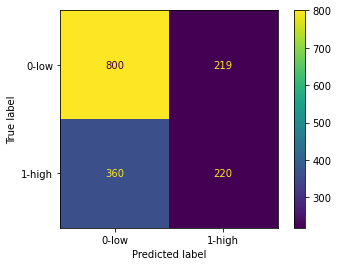

In [37]:
RF_cm = confusion_matrix(y_test, RF_pred, labels = SVM_fit.classes_)
RF_cmplot = ConfusionMatrixDisplay(RF_cm, display_labels = SVM_fit.classes_)
RF_cmplot.plot();

- finally visualize **feature importance** for the RF model
- SVMs and NNs do not have feature importance readily available, they are more black box models
- since the model does not (yet) performs well, the feature importance has not much meaning

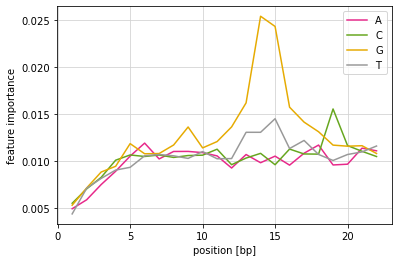

In [38]:
RF_feat_imp = pd.DataFrame()
RF_feat_imp['feat_imp'] = pd.Series(RF_fit.feature_importances_)
RF_feat_imp['position'] = np.repeat(np.arange(22), 5)
RF_feat_imp['base'] = ['A','C','G','T','N']*22
RF_feat_imp = RF_feat_imp.query('base != "N"')


fig, ax = plt.subplots()
ax.plot(np.arange(1,23), RF_feat_imp.query('base == "A"').feat_imp, label = 'A', color = colors['A'])
ax.plot(np.arange(1,23), RF_feat_imp.query('base == "C"').feat_imp, label = 'C', color = colors['C'])
ax.plot(np.arange(1,23), RF_feat_imp.query('base == "G"').feat_imp, label = 'G', color = colors['G'])
ax.plot(np.arange(1,23), RF_feat_imp.query('base == "T"').feat_imp, label = 'T', color = colors['T'])
ax.set_ylabel('feature importance')
ax.set_xlabel('position [bp]')
ax.legend()
ax.grid(color='lightgrey')
plt.savefig('../figures/plot_rf_feat_importance.svg')

## Model 3: Gradient boosting machine (GBM)

- based on decision trees, similar to RF

In [39]:
from sklearn.ensemble import GradientBoostingClassifier

In [40]:
%%time
# Model tuning
param_grid = {
    'loss': ['deviance', 'exponential'],
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.5],
    'max_depth': [1]}

GBM = GradientBoostingClassifier(random_state = 42)
GBM_tune = GridSearchCV(GBM, param_grid, n_jobs = -1)
GBM_tune.fit(x_train[: 2000], y_train[ : 2000])
print(GBM_tune.best_params_)

{'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 1, 'n_estimators': 300}
CPU times: user 1.93 s, sys: 44.5 ms, total: 1.97 s
Wall time: 53.9 s


In [41]:
# Model fitting & prediction
GBM = GradientBoostingClassifier(**GBM_tune.best_params_)
GBM_fit = GBM.fit(x_train, y_train)
GBM_pred = GBM_fit.predict(x_test)

In [42]:
print("GBM train accuracy: %0.3f" % GBM_tune.score(x_test, y_test))
print(classification_report(y_test, GBM_pred))

GBM train accuracy: 0.662
              precision    recall  f1-score   support

       0-low       0.68      0.89      0.77      1019
      1-high       0.57      0.26      0.36       580

    accuracy                           0.66      1599
   macro avg       0.63      0.58      0.57      1599
weighted avg       0.64      0.66      0.62      1599



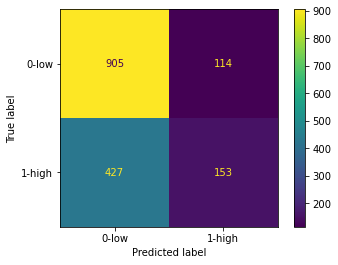

In [43]:
GBM_cm = confusion_matrix(y_test, GBM_pred, labels = SVM_fit.classes_)
GBM_cmplot = ConfusionMatrixDisplay(GBM_cm, display_labels = SVM_fit.classes_)
GBM_cmplot.plot();

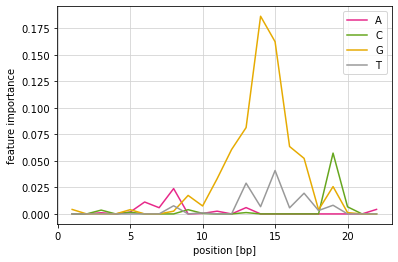

In [44]:
GBM_feat_imp = pd.DataFrame()
GBM_feat_imp['feat_imp'] = pd.Series(GBM_fit.feature_importances_)
GBM_feat_imp['position'] = np.repeat(np.arange(22), 5)
GBM_feat_imp['base'] = ['A','C','G','T','N']*22
GBM_feat_imp = GBM_feat_imp.query('base != "N"')


fig, ax = plt.subplots()
ax.plot(np.arange(1,23), GBM_feat_imp.query('base == "A"').feat_imp, label = 'A', color = colors['A'])
ax.plot(np.arange(1,23), GBM_feat_imp.query('base == "C"').feat_imp, label = 'C', color = colors['C'])
ax.plot(np.arange(1,23), GBM_feat_imp.query('base == "G"').feat_imp, label = 'G', color = colors['G'])
ax.plot(np.arange(1,23), GBM_feat_imp.query('base == "T"').feat_imp, label = 'T', color = colors['T'])
ax.set_ylabel('feature importance')
ax.set_xlabel('position [bp]')
ax.legend()
ax.grid(color='lightgrey')
plt.savefig('../figures/plot_gbm_feat_importance.svg')

Conclusions from all models so far:

- tree based methods performed less good than SVM
- tree-based methods had high recall/senstivity for low-eff sgRNAs, but low recall for high-eff sgRNAs
- feature importance from RF and GBM clearly shows that 
- further steps: try a CNN, or try to predict interesting seq features from SVM by probability

## Model 4: Multi-layer perceptron

- for this purpose we try tensorflow + keras
- some background: MLP or other neural networks consist of one or several layers of 'neurons' or nodes
- input data can be multidimensional, in our case it's simply a one-hot-encoded array of i observations x j features
- input features are passed to first layer of NN, transformed by a function, and passed to the next layer
- nodes are highly interconnected so that traits from multiple features get 'recognized' and passed to next layer
- each node generates only one output value $y$ from multiple feature inputs $x$: $y = \sigma \times (\sum(w_i \times x_i) + b)$
- with $x$ being a feature value, $w$ a weight factor, $b$ a learnable bias, and $\sigma$ an activation/cost function)
- training a neural network usually means to vary (optimize) the weight parameter $w$ for each node such that the cost (difference between expected output and obtained output) is minimized
- one difference to the other ML models is that target variable (labels) need to be one hot encoded too
- y therefore needs to be an array with i observations times j number of different labels
- the final layer of the model must have as many nodes as there are labels in the target variable (here: 2 or 3)

In [45]:
from keras import Sequential
from keras import layers
from keras import optimizers
from keras import utils

2022-03-31 14:10:11.194235: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-31 14:10:11.194277: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [46]:
# preprocess labels: convert to numerical, and also one-hot-encode
# similar to input features (binary output)
y_train_ohe = preprocessing.LabelEncoder().fit_transform(y = y_train)
y_test_ohe = preprocessing.LabelEncoder().fit_transform(y = y_test)

y_train_ohe = utils.np_utils.to_categorical(y_train_ohe, num_classes = len(list_bins))
y_test_ohe = utils.np_utils.to_categorical(y_test_ohe, num_classes = len(list_bins))

print(x_train.shape)
print(x_test.shape)
print(y_train_ohe.shape)
print(y_test_ohe.shape)

(4797, 110)
(1599, 110)
(4797, 2)
(1599, 2)


- build model

In [47]:
MLP = Sequential(name='MLP')

# Layer 1
MLP.add(layers.core.Dense(64, activation='relu', input_dim=x_train.shape[1]))
#MLP.add(layers.core.Dropout(rate=0.5))

# Layer 2
MLP.add(layers.core.Dense(128, activation='relu'))
#MLP.add(layers.core.Dropout(rate=0.5))

# Layer 3
MLP.add(layers.core.Dense(len(list_bins), activation='softmax'))
MLP.compile(optimizers.sgd_experimental.SGD(learning_rate = 0.01, momentum = 0.9, nesterov = True),
    loss='categorical_crossentropy',
    metrics=['accuracy'])

2022-03-31 14:10:15.033396: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-31 14:10:15.033437: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-31 14:10:15.033469: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (michael-asus): /proc/driver/nvidia/version does not exist
2022-03-31 14:10:15.034637: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [48]:
print(MLP.summary())

Model: "MLP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                7104      
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 dense_2 (Dense)             (None, 2)                 258       
                                                                 
Total params: 15,682
Trainable params: 15,682
Non-trainable params: 0
_________________________________________________________________
None


In [49]:
%%time
MLP_fit = MLP.fit(x_train, y_train_ohe, epochs = 200, batch_size = 32, verbose=False)

CPU times: user 1min 40s, sys: 6.83 s, total: 1min 47s
Wall time: 1min 10s


In [50]:
MLP.evaluate(x_test, y_test_ohe)
MLP_pred = MLP.predict(x_test)
MLP_pred.shape

50/50 [==============================] - 0s 2ms/step - loss: 3.7428 - accuracy: 0.5797


(1599, 2)

              precision    recall  f1-score   support

           0       0.68      0.64      0.66      1019
           1       0.43      0.47      0.45       580

    accuracy                           0.58      1599
   macro avg       0.55      0.56      0.55      1599
weighted avg       0.59      0.58      0.58      1599



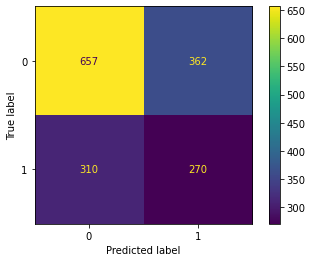

In [51]:
# convert OHE array back to factor with labels
y_test_class = np.argmax(y_test_ohe, axis=1)
y_pred_class = np.argmax(MLP_pred, axis=1)

MLP_cm = confusion_matrix(y_test_class, y_pred_class)
MLP_cmplot = ConfusionMatrixDisplay(MLP_cm)
MLP_cmplot.plot();
print(classification_report(y_test_class, y_pred_class))

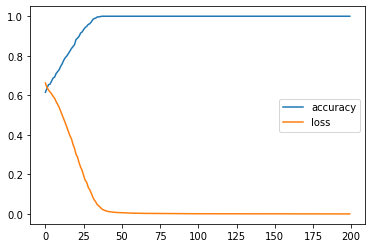

In [52]:
# plot accuracy and loss over model training
df_MLP = pd.DataFrame.from_dict(MLP_fit.history)
df_MLP['accuracy'].plot(legend = True);
df_MLP['loss'].plot(legend = True);

Conclusions:

- best performing models were SVM and MLP
- overall accuracy 60% which is not great
- precision and recall are highest (70%) for low efficency sgRNAs
- precision and recall around 50% for high efficiency sgRNAs

## Sequence motifs of high efficiency sgRNAs

- summarize predictions of all models ino rder to increase high confidence sgRNAs
- inspect sgRNAs with top predicted performance closer
- try to identify sequence patterns that might be enriched using clustering

In [53]:
# retrieve correctly identified sgRNAs from all 4 models (score between 0 and 4)
list_high_eff = (y_test_class == y_pred_class).astype(int) +\
    (y_test == SVM_pred).astype(int) +\
    (y_test == RF_pred).astype(int) +\
    (y_test == GBM_pred).astype(int)

print('High effiency sgRNAs in test data identified by at least one model: ' + str(sum(list_high_eff[y_test_class == 1] >= 1)))
print('High effiency sgRNAs in test data not identified any models: ' + str(sum(list_high_eff[y_test_class == 1] < 1)))

High effiency sgRNAs in test data identified by at least one model: 380
High effiency sgRNAs in test data not identified any models: 200


hits
0       200
1        99
2        81
3       103
4        97
dtype: int64


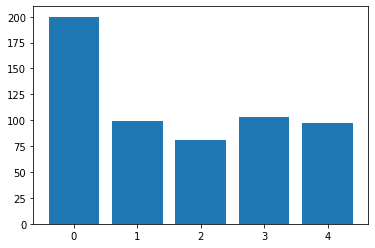

In [54]:
df_ensemble = pd.DataFrame(list_high_eff[y_test_class == 1], columns=['hits']).value_counts()
df_ensemble = df_ensemble.sort_index()
print(df_ensemble)

plt.bar(x = range(5), height=df_ensemble)
plt.savefig('../figures/plot_barchart_ML_recall.svg')

In [63]:
# logical with length of test data set indexing subset of
# true positive AND model positive sgRNAs
i_modelpos = i_test[np.logical_and(y_test_class == 1, list_high_eff >= 1)]
i_modelneg = i_test[np.logical_and(y_test_class == 1, list_high_eff <  1)]

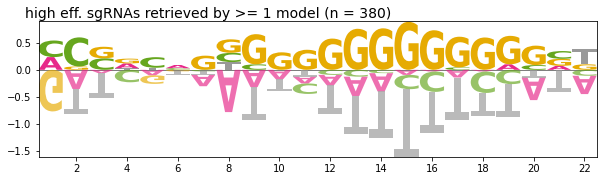

In [64]:
# Logo for high efficiency sgRNAs identified by ML models
plot_logo(
    fasta_df_reduced.iloc[i_modelpos].seq_pad,
    title = 'high eff. sgRNAs retrieved by >= 1 model',
    ylim = [-1.6, 0.9])

plt.savefig('../figures/logo_ML_1.pdf')

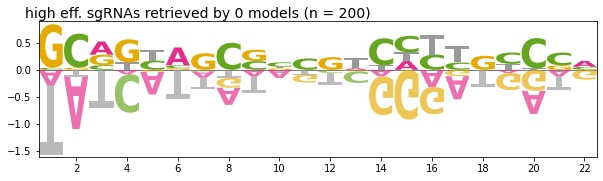

In [65]:
# Logo for high efficiency sgRNAs NOT identified by ML models
plot_logo(
    fasta_df_reduced.iloc[i_modelneg].seq_pad,
    title = 'high eff. sgRNAs retrieved by 0 models',
    ylim = [-1.6, 0.9])

plt.savefig('../figures/logo_ML_2.pdf')

## Pie charts to summarize sgRNAs used for modeling

Simple pie charts showing fractions of:

- used sgRNAs (genes) vs all sgRNAs (genes) (2 fractions)
- low efficiency vs high efficiency sgRNAs (2 fractions)
- train and test sets, of the latter the model identified and non-identified high eff subset (3 fractions)data


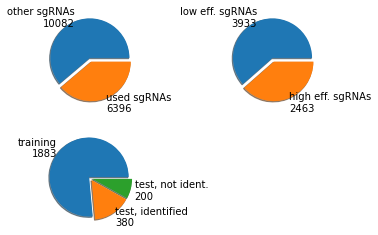

In [58]:
# Make figure and axes
fig, axs = plt.subplots(2, 2)

# Pie 1: total vs used sgRNAs
n_total_sgRNA = len(data.sgRNA.unique())
n_used_sgRNA = len(data_reduced.sgRNA.unique())

axs[0, 0].pie(
    [n_total_sgRNA-n_used_sgRNA, n_used_sgRNA],
    labels=['other sgRNAs\n{}'.format(n_total_sgRNA-n_used_sgRNA), 'used sgRNAs\n{}'.format(n_used_sgRNA)],
    shadow=True, explode=[0.05,0.05])

# Pie 2: low vs high eff sgRNAs
n_low_high_sgRNA = data_bin_sum.to_list()
axs[0, 1].pie(
    n_low_high_sgRNA,
    labels=['low eff. sgRNAs\n{}'.format(n_low_high_sgRNA[0]), 'high eff. sgRNAs\n{}'.format(n_low_high_sgRNA[1])],
    shadow=True, explode=[0.05,0.05])

# Pie 3: train and test set, test subdivided in ML+ and ML-
n_train_test = [fasta_df_reduced.iloc[i_train].query('efficiency_binned=="1-high"').shape[0],
    len(i_modelpos), len(i_nodelneg)]
axs[1, 0].pie(
    n_train_test,
    labels=['training\n{}'.format(n_train_test[0]),
        'test, identified\n{}'.format(n_train_test[1]),
        'test, not ident.\n{}'.format(n_train_test[2])],
    shadow=True, explode=[0.05,0.05,0.05])

# Hide last position
axs[1, 1].axis('off')

plt.savefig('../figures/piechart_ML.svg')

## GC content as efficiency predictor

- it is obvious that some of the "quality" (or efficiency) can be explained by GC content
- as a matter of fact, all high eff sgRNAs seem to have higher GC content from logo pattern

GC content needs to be investigated as a confounding variable, because that alone would be a better predictor than sequence motifs.
However if ML models pick GC content up as predictor, it's not wrong, only less useful

- task 1: quantify GC content per group and compare high and low efficiency
- task 2: quantify GC skew per group
- task 3: if necessary, balance the groups such that average GC content is even

In [59]:
fasta_df_reduced['GC_content'] = fasta_df_reduced.seq.apply(Bio.SeqUtils.GC)
fasta_df_reduced['GC_skew'] = [Bio.SeqUtils.GC_skew(i, window = 100)[0] for i in fasta_df_reduced.seq]

Task 1: Average GC content per group:

- high vs low efficiency sgRNAs, total dataset (6400 sgRNAs)
- high efficiency sgRNAs, model-retrieved versus non-retrieved (400 vs 200 sgRNAs)

Mean GC content for 0-low is: 53.02
Mean GC content for 1-high is: 55.29


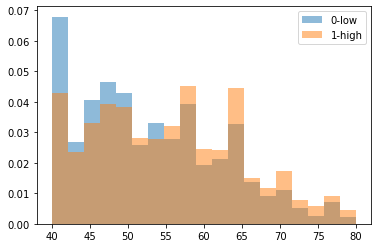

In [89]:
plt.figure(figsize=(6,4))
for eff in list_bins:
    eff_subset = fasta_df_reduced[fasta_df_reduced.efficiency_binned == eff]['GC_content']
    plt.hist(eff_subset, bins = 19, alpha = 0.5, label = eff, density = True)
    print('Mean GC content for {0} is: {1}'.format(eff, str(round(eff_subset.mean(), 2))))
plt.legend(loc = 'upper right')

Mean GC content for true pos is: 57.93
Mean GC content for false neg is: 52.45


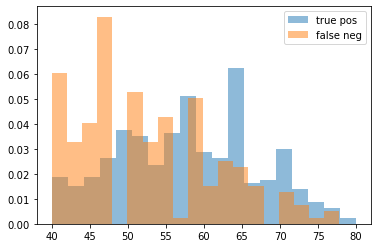

In [90]:
plt.figure(figsize=(6,4))
dict_groups = {'true pos': i_modelpos, 'false neg': i_modelneg}
for group in dict_groups:
    eff_subset = fasta_df_reduced.iloc[dict_groups.get(group)].GC_content
    plt.hist(eff_subset, bins = 19, alpha = 0.5, label = group, density = True)
    print('Mean GC content for {0} is: {1}'.format(group, str(round(eff_subset.mean(), 2))))
plt.legend(loc = 'upper right')

Task 2: GC skew per group

- high vs low efficiency sgRNAs, total dataset (6400 sgRNAs)
- high efficiency sgRNAs, model-retrieved versus non-retrieved (400 vs 200 sgRNAs)

Mean GC skew for 0-low is: -0.02
Mean GC skew for 1-high is: 0.09


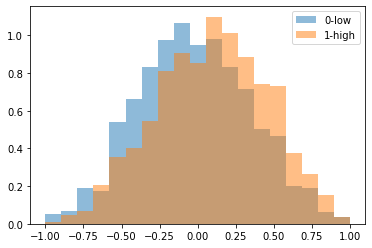

In [61]:
plt.figure(figsize=(6,4))
for eff in list_bins:
    eff_subset = fasta_df_reduced[fasta_df_reduced.efficiency_binned == eff]['GC_skew']
    plt.hist(eff_subset, bins = 19, alpha = 0.5, label = eff, density = True)
    print('Mean GC skew for {0} is: {1}'.format(eff, str(round(eff_subset.mean(), 2))))
plt.legend(loc = 'upper right')

Mean GC skew for true pos is: 0.16
Mean GC skew for false neg is: -0.07


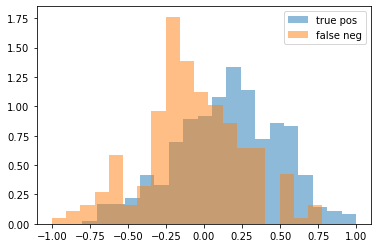

In [93]:
plt.figure(figsize=(6,4))
for group in dict_groups:
    eff_subset = fasta_df_reduced.iloc[dict_groups.get(group)].GC_skew
    plt.hist(eff_subset, bins = 19, alpha = 0.5, label = group, density = True)
    print('Mean GC skew for {0} is: {1}'.format(group, str(round(eff_subset.mean(), 2))))
plt.legend(loc = 'upper right')

Test if GC content is significantly different for low and high-efficiency sgRNAs. We use a non-parametric test because the distribution is not normal/gaussian.

In [62]:
from scipy import stats
for metric in ['GC_content', 'GC_skew']:    
    wilcox = stats.ranksums(
        fasta_df_reduced[fasta_df_reduced.efficiency_binned == '0-low'][metric],
        fasta_df_reduced[fasta_df_reduced.efficiency_binned == '1-high'][metric],
        alternative='two-sided'
    )
    print(wilcox)

RanksumsResult(statistic=-9.129622517160762, pvalue=6.873855194744912e-20)
RanksumsResult(statistic=-11.95422435599486, pvalue=6.170702470097435e-33)


The same test for the high efficiency sgRNAs, model-retrieved versus non-retrieved (400 vs 200 sgRNAs)

In [92]:
for metric in ['GC_content', 'GC_skew']:    
    wilcox = stats.ranksums(
        fasta_df_reduced.iloc[dict_groups.get('true pos')][metric],
        fasta_df_reduced.iloc[dict_groups.get('false neg')][metric],
        alternative='two-sided'
    )
    print(wilcox)

RanksumsResult(statistic=6.833587490863744, pvalue=8.281694798429257e-12)
RanksumsResult(statistic=7.468803294168277, pvalue=8.092740673145877e-14)


Summary:

- average GC content is 2% higher in high eff. sgRNAs, not substantially
- difference in GC content is small but signigicant (p ~ 10^-20)
- average GC skew (G-C)/(G+C) is -0.02 in low eff sgRNAs, and 0.09 in high eff sgRNAs
- that corresponds to around +1G for every 5C in high eff sgRNAs
- also this difference is was highly significant
- average GC content between model-retrieved and non-retrieved high eff sgRNAs is more different (5.5%)
- same for GC skew, difference twice as high as high-vs-low effiency comparison

Conclusion:

- therefore, models succeeded to predict high eff sgRNAs _if they have high GC content_ but otherwise not
- we can not say that GC content is the best/only predictor, as the original data set is balanced
- high eff sgRNAs _with low GC content_ apparently evade prediction due to lack of other good features